# Porkchop plots

This tutorial showcases how to create a porkchop plot using Python and PySTK.

## What is a porkchop plot?

A porkchop plot is a graphical tool used in astrodynamics to visualize the fuel or energy requirements for space missions, especially interplanetary travel. It shows contours of mission parameters, typically launch and arrival dates, with color-coded regions indicating different energy costs. The plot's shape often resembles a porkchop, hence the name.

Porkchop plots are usually generated under the assumption of the restricted two-body problem. The restricted two-body problem assumes that each planet is treated as a single point mass, focusing solely on the gravitational influence of the Sun. This simplifies the model by ignoring gravitational interactions between planets, allowing spacecraft trajectories to be calculated based only on the Sun's and a single planet's gravity. The trajectory of the spacecraft is computed by solving a [Lambert transfer](./lambert-transfer.py).

## Problem statement

The goal of this tutorial is to reproduce the porkchop in Fig. 4 from  NASA's Interplanetary Mission Design Handbook, Volume I, Part 2, available for download [here](https://ntrs.nasa.gov/citations/19840010158). This porkchop shows the characteristic energy at launch $C_{3_{\text{launch}}} = \Delta v_{\text{launch}}^2$ for a interplanetary Lambert transfer between Earth and Mars.

![Fig. 7 directly taken from NASA's manual](./img/nasa-porkchop.png)

## Overview of the algorithm

Solving for a porkchop requires various steps:

- Generating a span of launch and arrival dates
- Solving the position of the planets for each combination of launch and arrival dates
- Solving the Lambert transfer for each combination of planetary positions
- Computing the characteristic energy at launch
- Collecting all the solutions and generating the contour map

Some of these steps can be implemented as functions to ease the readability of the code and its maintenance.

## Launch STK

Start by launching a new STK instance in headless mode (no GUI):

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Next, create a new scenario. The central body for this scenario must be the Sun.

In [2]:
from ansys.stk.core.stkobjects import STKObjectType


root = stk.new_object_root()
scenario = root.children.new_on_central_body(
    STKObjectType.SCENARIO, "PorkchopPlot", "Sun"
)

## Generating a span of launch and arrival dates

Generating a span of launch and arrival dates allows to compute, in the future, for any combination of dates. When manipulating dates and times in PySTK, it is important to always use the API. Do not rely on the Python <inv:datetime> module since it does not account for leap-seconds.

In [3]:
def linspace_dates(start_date, end_date, interval, unit):
    """Generate a list of linearly spaced dates.

    Parameters
    ----------
    start_date : ~ansys.stk.core.stkutil.Date
        Date to start the generation.
    end_date : ~ansys.stk.core.stkutil.Date
        Date to end the generation.
    interval : float
        Desired time interval between generated dates.
    unit : str
        Name of the units associated to the time interval.

    Returns
    -------
    dates : list[~ansys.stk.core.stkutil.Date]
        List of dates linearly spaced by the desired interval.

    """
    dates = []
    next_date = start_date
    while next_date.whole_days <= end_date.whole_days:
        dates.append(next_date)
        next_date = next_date.add(unit, interval)
    return dates

Declare the launch and arrival boundary dates as shown in the original figure by NASA:

In [4]:
first_launch, last_launch = [
    root.conversion_utility.new_date("UTCG", date)
    for date in ["29 May 1990", "5 Nov 1990"]
]
first_arrival, last_arrival = [
    root.conversion_utility.new_date("UTCG", date)
    for date in ["25 Nov 1990", "30 Dec 1991"]
]

Then, generate the launch and arrival date spans:

In [5]:
launch_span = linspace_dates(first_launch, last_launch, 3, "day")
arrival_span = linspace_dates(first_arrival, last_arrival, 3, "day")

It is possible to print previous lists to verify the values they contain:

In [6]:
print("Launch span", end=": ")
for date in linspace_dates(first_launch, last_launch, 1, "day")[:5]:
    print(date.format("UTCG"), end=", ")
print("...")

Launch span: 29 May 1990 00:00:00.000, 30 May 1990 00:00:00.000, 31 May 1990 00:00:00.000, 1 Jun 1990 00:00:00.000, 2 Jun 1990 00:00:00.000, ...


## Solve the ephemerides of the planets

With launch and arrival dates generated, it is time to generate a routine for computing the state vector of the planets. This function was presented in the [Lambert transfer](./lambert-transfer.py) example. Therefore, it is reproduced in here:

In [7]:
def from_data_result_to_dict(data_result: "DataProviderResult") -> dict:
    """Convert a data provider result to a dictionary.

    Parameters
    ----------
    data_result : DataProviderResult
        Data result instance to be converted.

    Returns
    -------
    dict
        Dictionary representing the elements and values of the data provider.

    """
    return {
        key: data_result.data_sets.item(key_id).get_values()
        for key_id, key in enumerate(data_result.data_sets.element_names)
    }


def get_object_pos_vel_at_epoch(
    stk_object: "STKObject", epoch: str, frame_name: str
) -> tuple:
    """Compute the position and velocity vectors of an object in the desired reference frame.

    Parameters
    ----------
    stk_object : ~ansys.stkcore.stkobjects.STKObject
        Name of the object.
    epoch : ~ansys.stk.core.stkutil.Date
        Epoch date.
    frame_name : str
        Reference frame name.

    Returns
    -------
    tuple(list[float, float, float], list[float, float, float])
        Tuple containing the position and velocity vectors as a list.

    """
    state = {"Position": None, "Velocity": None}
    for path in state:
        data_provider = (
            stk_object.data_providers.get_data_provider_time_varying_from_path(
                f"Cartesian {path}/{frame_name}"
            )
        )
        data = from_data_result_to_dict(
            data_provider.execute_single_elements(epoch.format("UTCG"), ["x", "y", "z"])
        )
        state[path] = [coord[0] for coord in data.values()]
    return tuple(state.values())

Now, add the planets to the scene:

In [8]:
from ansys.stk.core.stkobjects import EphemSourceType, PlanetPositionSourceType


for name in ["Earth", "Mars"]:
    planet = scenario.children.new_on_central_body(STKObjectType.PLANET, name, "Sun")
    planet.common_tasks.set_position_source_central_body(name, EphemSourceType.DEFAULT)

earth, mars = [scenario.children[object_name] for object_name in ["Earth", "Mars"]]

It is possible to print the position at one date to verify previous functions. The position of the Earth for the first launch days is computed:

In [9]:
print("Earth ephemerides")
print("=================\n")

print(f"{'Date':<25} {'Position':<47} {'Velocity':<50}")
print(f"{'----':<25} {45 * '-':<47} {25 * '-':<50}")
for date in launch_span[:5]:
    (rx, ry, rz), (vx, vy, vz) = get_object_pos_vel_at_epoch(earth, date, "ICRF")
    print(
        f"{date.format('UTCG'):<25} [{rx:>10.2f}, {ry:>10.2f}, {rz:>10.2f}] km   [{vx:>3.2f}, {vy:>3.2f}, {vz:>3.2f}] km/s "
    )
print("...")

Earth ephemerides

Date                      Position                                        Velocity                                          
----                      ---------------------------------------------   -------------------------                         
29 May 1990 00:00:00.000  [-57973714.01, -128535857.92, -55730606.57] km   [27.05, -10.55, -4.57] km/s 
1 Jun 1990 00:00:00.000   [-50891797.48, -131103475.18, -56843561.68] km   [27.58, -9.26, -4.01] km/s 
4 Jun 1990 00:00:00.000   [-43681896.13, -133335785.54, -57811257.78] km   [28.04, -7.96, -3.45] km/s 
7 Jun 1990 00:00:00.000   [-36362341.89, -135228643.32, -58631957.88] km   [28.43, -6.64, -2.88] km/s 
10 Jun 1990 00:00:00.000  [-28951096.38, -136778432.41, -59304085.80] km   [28.75, -5.31, -2.30] km/s 
...


## Add a satellite

A satellite object is used to solve for the Lambert transfer between Earth and Mars. Astrogator is used for its propagation. Make sure to clean the main sequence.

In [10]:
from ansys.stk.core.stkobjects import PropagatorType


satellite = scenario.children.new_on_central_body(
    STKObjectType.SATELLITE, "Satellite", "Sun"
)
satellite.set_propagator_type(PropagatorType.ASTROGATOR)
satellite.propagator.main_sequence.remove_all()

### Initial state

The initial state of the satellite must be changed for every launch date. However, the initial state segment instance remains in the main sequence. Therefore, it is possible to configure here only the constant parameters of the initial state of the satellite:

In [11]:
from ansys.stk.core.stkobjects.astrogator import ElementSetType, SegmentType


initial_state = satellite.propagator.main_sequence.insert(
    SegmentType.INITIAL_STATE, "Initial State", "-"
)
initial_state.coord_system_name = "CentralBody/Sun Inertial"
initial_state.set_element_type(ElementSetType.CARTESIAN)

### Interplanetary transfer

For the interplanetary transfer, a similar situation occurs. The different segments of the Lambert trajectory remain no matter the launch and arrival dates. Therefore, it is possible configure here only the constant parameters.

Start by declaring the different segments of the Lambert transfer:

In [12]:
transfer = satellite.propagator.main_sequence.insert(
    SegmentType.TARGET_SEQUENCE, "Lambert Transfer", "-"
)
first_impulse = transfer.segments.insert(SegmentType.MANEUVER, "First Impulse", "-")
propagate = transfer.segments.insert(SegmentType.PROPAGATE, "Propagate", "-")
last_impulse = transfer.segments.insert(SegmentType.MANEUVER, "Last Impulse", "-")

Configure the type of segments:

In [13]:
from ansys.stk.core.stkobjects.astrogator import ManeuverType


first_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)
propagate.propagator_name = "Sun Point Mass"
last_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)

Add a Lambert profile to the interplanetary transfer:

In [14]:
transfer.profiles.remove_all()
lambert = transfer.profiles.add("Lambert Profile")

Configure the profile. Do not configure any parameters related with the target:

In [15]:
from ansys.stk.core.stkobjects.astrogator import (
    LambertSolutionOptionType,
    LambertTargetCoordinateType,
)


lambert.coord_system_name = "CentralBody/Sun Inertial"
lambert.set_target_coord_type(LambertTargetCoordinateType.CARTESIAN)
lambert.enable_second_maneuver = True

lambert.solution_option = LambertSolutionOptionType.FIXED_TIME
lambert.revolutions = 0
lambert.central_body_collision_altitude_padding = 0

Allow the profile to write its results to the transfer segments:

In [16]:
lambert.enable_write_to_first_maneuver = True
lambert.first_maneuver_segment = first_impulse.name

lambert.enable_write_duration_to_propagate = True
lambert.disable_non_lambert_propagate_stop_conditions = True
lambert.propagate_segment = propagate.name

lambert.enable_write_to_second_maneuver = True
lambert.second_maneuver_segment = last_impulse.name

Activate the profile and configure its behavior when solving for the results:

In [17]:
from ansys.stk.core.stkobjects.astrogator import (
    ProfileMode,
    ProfilesFinish,
    TargetSequenceAction,
)


lambert.mode = ProfileMode.ACTIVE
transfer.action = TargetSequenceAction.RUN_ACTIVE_PROFILES
transfer.when_profiles_finish = ProfilesFinish.RUN_TO_RETURN_AND_CONTINUE
transfer.continue_on_failure = False
transfer.reset_inner_targeters = False

## Solve the transfer

Only the constant parameters have been configured so far. Now, it is time to create a routine capable of modifying the state of the satellite and the Lambert profile so that the required impulses can be solved for any launch and arrival date.

**Note:** the porkchop plots presented in NASA's manual assume prograde transfers. However, the Lambert profile only differentiates between long and short solution transfers. The relation between prograde/retrograde and long/short transfers is set by the angular momentum. Although its magnitude can not be found unless solving the problem, its direction can be retrieved from the initial and final position vectors. Therefore, depending on the angular momentum, a long or short transfer is imposed.

In [18]:
import numpy as np

from ansys.stk.core.stkobjects.astrogator import LambertDirectionOfMotionType


def lambert_solver(
    satellite, departure_body, arrival_body, launch_date, arrival_date, is_prograde=True
):
    """Solve the Lambert transfer between two bodies for a given launch and arrival date."""
    # Retrieve the initial state and lambert profile from the satellite
    initial_state = satellite.propagator.main_sequence["Initial State"]
    lambert = satellite.propagator.main_sequence["Lambert Transfer"].profiles[
        "Lambert Profile"
    ]

    # Compute the time of flight
    time_of_flight = arrival_date.span(launch_date).value
    if time_of_flight <= 0:
        return None, None, None
    lambert.time_of_flight = time_of_flight

    # Compute the departure and arrival state vectors
    departure_position, departure_velocity = get_object_pos_vel_at_epoch(
        departure_body, launch_date, "ICRF"
    )
    arrival_position, arrival_velocity = get_object_pos_vel_at_epoch(
        arrival_body, arrival_date, "ICRF"
    )

    # Impose the direction of motion according to the angular momentum of the orbit
    r1_cross_r2 = np.cross(departure_position, arrival_position)
    r1_times_r2 = np.linalg.norm(departure_position) * np.linalg.norm(arrival_position)
    h0_z = (r1_cross_r2 / r1_times_r2)[-1]

    if is_prograde:
        path = (
            LambertDirectionOfMotionType.LONG
            if h0_z < 0
            else LambertDirectionOfMotionType.SHORT
        )
    else:
        path = (
            LambertDirectionOfMotionType.SHORT
            if h0_z < 0
            else LambertDirectionOfMotionType.LONG
        )
    lambert.direction_of_motion = path

    # Update the initial state of the satellite
    initial_state.orbit_epoch = launch_date.format("UTCG")
    initial_state.element.x = departure_position[0]
    initial_state.element.y = departure_position[1]
    initial_state.element.z = departure_position[2]
    initial_state.element.vx = departure_velocity[0]
    initial_state.element.vy = departure_velocity[1]
    initial_state.element.vz = departure_velocity[2]

    # Update final state of satellite
    lambert.target_position_x = arrival_position[0] * 1000
    lambert.target_position_y = arrival_position[1] * 1000
    lambert.target_position_z = arrival_position[2] * 1000
    lambert.target_velocity_x = arrival_velocity[0] * 1000
    lambert.target_velocity_y = arrival_velocity[1] * 1000
    lambert.target_velocity_z = arrival_velocity[2] * 1000

    # Run the mission control sequence
    satellite.propagator.run_mcs()
    satellite.propagator.apply_all_profile_changes()

    # Compute the impulses
    delta_v1 = first_impulse.maneuver.attitude_control.magnitude / 1000
    delta_v2 = last_impulse.maneuver.attitude_control.magnitude / 1000

    return delta_v1, delta_v2, time_of_flight

Finally, solve the transfer for every launch and arrival date combination:

In [19]:
dv_arrival_values = np.zeros((len(arrival_span), len(launch_span)))
c3_launch_values = np.zeros((len(arrival_span), len(launch_span)))
tof_values = np.zeros((len(arrival_span), len(launch_span)))

for i, launch_date in enumerate(launch_span):
    for j, arrival_date in enumerate(arrival_span):
        dv_launch, dv_arrival, tof = lambert_solver(
            satellite, earth, mars, launch_date, arrival_date
        )

        dv_arrival_values[j, i] = dv_arrival
        c3_launch_values[j, i] = dv_launch**2
        tof_values[j, i] = tof / 3600 / 24

## Plot the porkchop

With the values for $C_{3_{\text{launch}}}$, $\Delta v_{\text{arrival}}$, and the time of flight, it is possible to generate the porkchop plot. However, before proceeding, we need to convert the `Date` objects to `datetime.datetime` objects so that Matplotlib can correctly interpret them as time values.

In [20]:
from datetime import datetime


def as_datetime(date):
    """Convert a :ref:`~Date` object into a :ref:`~datetime.datetime` instance.

    Warns
    -----
    If a leap second is casted, one second is subtracted.

    Note
    ----
    Casting as Python dates introduces a loss of precision. Avoid using casted
    date types in future computations.

    """
    utcg_format_str = "%d %b %Y %H:%M:%S.%f"
    try:
        return datetime.strptime(date.format("UTCG"), utcg_format_str)
    except ValueError as LeapSecondsError:
        import warnings

        warnings.warn(f"Date {date.format('UTCG')} is a leap second.")
        adjusted_date = date.subtract("sec", 1)
        return datetime.strptime(adjusted_date.format("UTCG"), utcg_format_str)

Cast dates to ensure Matplotlib representation:

In [21]:
launch_span = [as_datetime(date) for date in launch_span]
arrival_span = [as_datetime(date) for date in arrival_span]

To increase the beauty of the porkchop plot, the following contour levels apply:

In [22]:
c3_launch_levels = np.linspace(0, 45, 19)
dv_arrival_levels = np.linspace(0, 5, 6)
tof_levels = np.linspace(0, 400, 5)

Finally, plot the porkchop

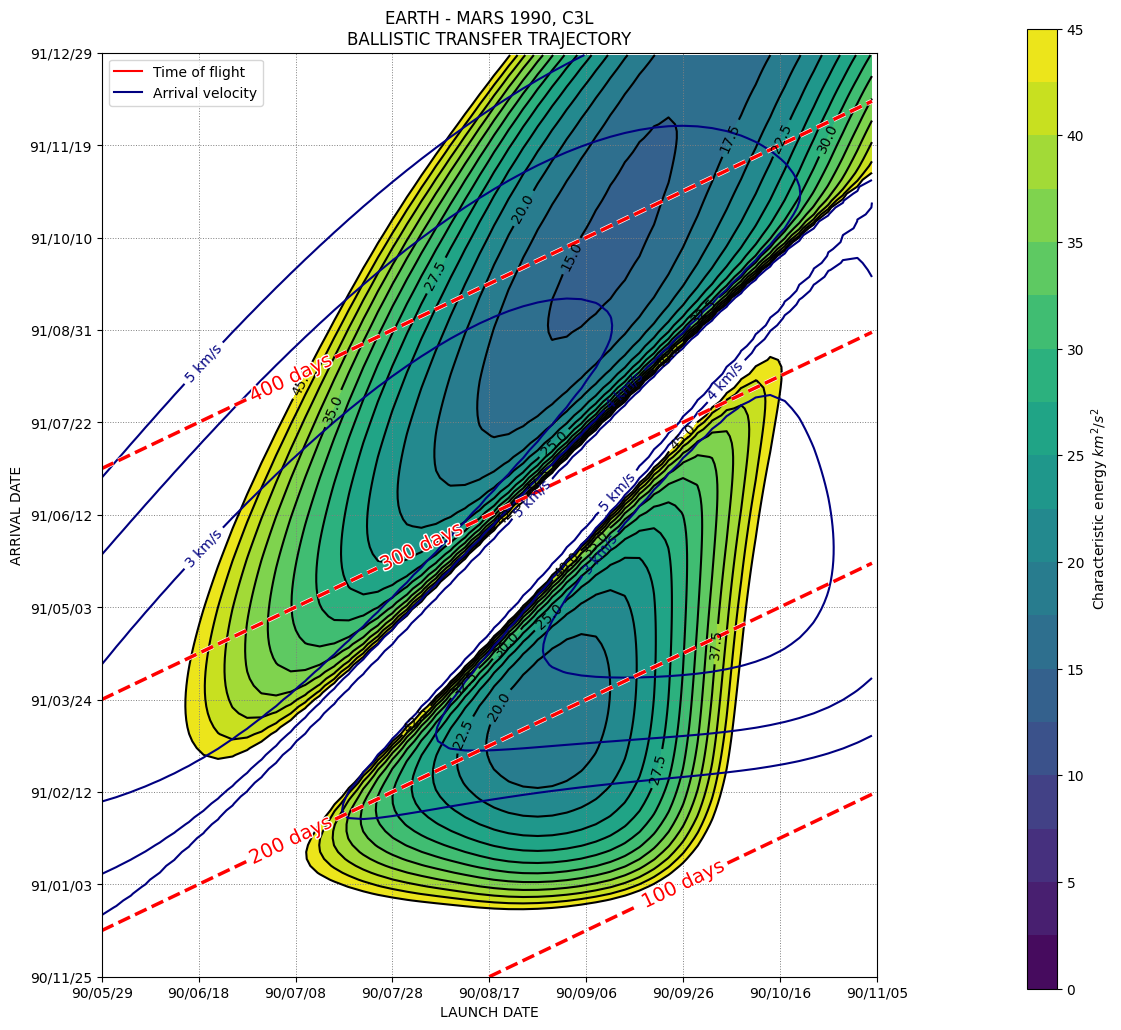

In [23]:
from matplotlib import patheffects
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 12))

ax.set_title("EARTH - MARS 1990, C3L\nBALLISTIC TRANSFER TRAJECTORY")
ax.set_xlabel("LAUNCH DATE")
ax.set_ylabel("ARRIVAL DATE")

# Contour color for the characteristic energy
c3_colors = ax.contourf(launch_span, arrival_span, c3_launch_values, c3_launch_levels)
c3_colorbar_axes = fig.add_axes([1.05, 0.1, 0.03, 0.8])
c3_colorbar = fig.colorbar(c3_colors, c3_colorbar_axes)
c3_colorbar.set_label("Characteristic energy $km^2 / s^2$")

# Contour lines for the characteristic energy
c3_lines = ax.contour(
    launch_span,
    arrival_span,
    c3_launch_values,
    c3_launch_levels,
    colors="black",
    linestyles="solid",
)
ax.clabel(c3_lines, inline=1, fmt="%1.1f", colors="k", fontsize=10)

# Lines for the arrival velocity
dv_arrival_lines = ax.contour(
    launch_span,
    arrival_span,
    dv_arrival_values,
    dv_arrival_levels,
    colors="navy",
    linestyles="solid",
)
dv_arrival_labels = ax.clabel(
    dv_arrival_lines, inline=1, fmt="%1.0f km/s", colors="navy", fontsize=10
)

# Lines for the time of flight
tof_lines = ax.contour(
    launch_span,
    arrival_span,
    tof_values,
    tof_levels,
    colors="red",
    linestyles="dashed",
    linewidths=2.5,
)
tof_lines.set(path_effects=[patheffects.withStroke(linewidth=3.5, foreground="w")])
tof_labels = ax.clabel(
    tof_lines,
    inline=True,
    fmt="%1.0f days",
    colors="red",
    fontsize=14,
    use_clabeltext=True,
)
plt.setp(tof_labels, path_effects=[patheffects.withStroke(linewidth=2, foreground="w")])

# Format dates shown in the axes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
ax.yaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
plt.xticks(rotation=90)

# Set the ticks for bot axes
ax.set_xticks(
    [as_datetime(date) for date in linspace_dates(first_launch, last_launch, 20, "day")]
)
ax.set_yticks(
    [
        as_datetime(date)
        for date in linspace_dates(first_arrival, last_arrival, 40, "day")
    ]
)

# Custom legend
legend_lines = [
    mlines.Line2D([], [], color="red", label="Time of flight"),
    mlines.Line2D([], [], color="navy", label="Arrival velocity"),
]
ax.legend(handles=legend_lines, loc="upper left")

ax.grid(True, which="both", axis="both", color="gray", linestyle=":", linewidth=0.7)
plt.show()